# Certification of Vision Transformers

In this notebook we will go over how to use the PyTorchSmoothedViT tool and be able to certify vision transformers against patch attacks!

### Overview

This method was introduced in Certified Patch Robustness via Smoothed Vision Transformers (https://arxiv.org/abs/2110.07719). The core technique is one of *image ablations*, where the image is blanked out except for certain regions. By ablating the input in different ways every time we can obtain many predicitons for a single input. Now, as we are ablating large parts of the image the attacker's patch attack is also getting removed in many predictions. Based on factors like the size of the adversarial patch and the size of the retained part of the image the attacker will only be able to influence a limited number of predictions. In fact, if the attacker has a $m x m$ patch attack and the retained part of the image is a column of width $s$ then the maximum number of predictions $\Delta$ that could be affected are: 

<p style="text-align: center;"> $\Delta = m + s - 1$ </p>

Based on this relationship we can derive a simple but effective criterion that if we are making many predictions for an image and the highest predicted class $c_t$ has been predicted $k_t$ times and the second most predicted class $c_{t-1}$ has been predicted $k_{t-1}$ times then we have a certified prediction for $c_t$ if: 


<p style="text-align: center;"> $k_t -  k_{t-1} > 2\Delta$  </p>

Intuitivly we are saying that even if $k$ predictions were adversarially influenced and those predictions were to change, then the model will *still* have predicted class $c_t$.

### What's special about Vision Transformers?

The formulation above is very generic and it can be applied to any nerual network model, in fact the original paper which proposed it (https://arxiv.org/abs/2110.07719) considered the case with convolutional nerual networks. 

However, Vision Transformers (ViTs) are well siuted to this task of predicting with vision ablations for two key reasons: 

+ ViTs first tokenize the input into a series of image regions which get embedded and then processed through the neural network. Thus, by considering the input as a set of tokens we can drop tokens which correspond to fully masked (i.e ablated)regions significantly saving on the compute costs. 

+ Secondly, the ViT's self attention layer enables sharing of information globally at every layer. In contrast convolutional neural networks build up the receptive field over a series of layers. Hence, ViTs can be more effective at classifying an image based on its small unablated regions.

Let's see how to use these tools!

In [1]:
import sys
import numpy as np
import torch

sys.path.append("..")
from torchvision import datasets
from matplotlib import pyplot as plt

# The core tool is PyTorchSmoothedViT which can be imported as follows:
from art.estimators.certification.derandomized_smoothing import PyTorchDeRandomizedSmoothing

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Function to fetch the cifar-10 data
def get_cifar_data():
    """
    Get CIFAR-10 data.
    :return: cifar train/test data.
    """
    train_set = datasets.CIFAR10('./data', train=True, download=True)
    test_set = datasets.CIFAR10('./data', train=False, download=True)

    x_train = train_set.data.astype(np.float32)
    y_train = np.asarray(train_set.targets)

    x_test = test_set.data.astype(np.float32)
    y_test = np.asarray(test_set.targets)

    x_train = np.moveaxis(x_train, [3], [1])
    x_test = np.moveaxis(x_test, [3], [1])

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    return (x_train, y_train), (x_test, y_test)


(x_train, y_train), (x_test, y_test) = get_cifar_data()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# There are a few ways we can interface with PyTorchSmoothedViT. 
# The most direct way to get setup is by specifying the name of a supported transformer.
# Behind the scenes we are using the timm library (link: https://github.com/huggingface/pytorch-image-models).


# We currently support ViTs generated via: 
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
# Support for other architectures can be added in. Consider raising a feature or pull request to have 
# additional models supported.

# We can see all the models supported by using the .get_models() method:
PyTorchDeRandomizedSmoothing.get_models()

['vit_base_patch8_224',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32_plus_256',
 'vit_giant_patch14_224',
 'vit_giant_patch14_clip_224',
 'vit_gigantic_patch14_224',
 'vit_gigantic_patch14_clip_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_clip_224',
 'vit_huge_patch14_clip_336',
 'vit_huge_patch14_xp_224',
 'vit_large_patch14_224',
 'vit_large_patch14_clip_224',
 'vit_large_patch14_clip_336',
 'vit_large_patch14_xp_224',
 'vit_large_patch16_224',
 'vit_large_patch16_384',
 'vit_large_patch32_224',
 'vit_large_patch32_384',
 'vit_medium_patch16_gap_240',
 'vit_medium_patch16_gap_256',
 'vi

In [4]:
import timm

# We can setup the PyTorchSmoothedViT if we start with a ViT model directly.

vit_model = timm.create_model('vit_small_patch16_224')
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-4)

art_model = PyTorchDeRandomizedSmoothing(model=vit_model, # Name of the model acitecture to load
                                         loss=torch.nn.CrossEntropyLoss(), # loss function to use
                                         optimizer=optimizer, # the optimizer to use: note! this is not initialised here we just supply the class!
                                         input_shape=(3, 32, 32), # the input shape of the data: Note! that if this is a different shape to what the ViT expects it will be re-scaled
                                         nb_classes=10,
                                         ablation_size=4, # Size of the retained column
                                         replace_last_layer=True, # Replace the last layer with a new set of weights to fine tune on new data
                                         load_pretrained=True) # if to load pre-trained weights for the ViT

INFO:root:Running algorithm: salman2021
INFO:root:Converting Adam Optimiser
INFO:art.estimators.classification.pytorch:Inferred 9 hidden layers on PyTorch classifier.
INFO:art.estimators.certification.derandomized_smoothing.pytorch:PyTorchViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06,

In [5]:
# Or we can just feed in the model name and ART will internally create the ViT.

art_model = PyTorchDeRandomizedSmoothing(model='vit_small_patch16_224', # Name of the model acitecture to load
                                        loss=torch.nn.CrossEntropyLoss(), # loss function to use
                                        optimizer=torch.optim.SGD, # the optimizer to use: note! this is not initialised here we just supply the class!
                                        optimizer_params={"lr": 0.01}, # the parameters to use
                                        input_shape=(3, 32, 32), # the input shape of the data: Note! that if this is a different shape to what the ViT expects it will be re-scaled
                                        nb_classes=10,
                                        ablation_size=4, # Size of the retained column
                                        replace_last_layer=True, # Replace the last layer with a new set of weights to fine tune on new data
                                        load_pretrained=True) # if to load pre-trained weights for the ViT

INFO:root:Running algorithm: salman2021
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_small_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:art.estimators.classification.pytorch:Inferred 9 hidden layers on PyTorch classifier.
INFO:art.estimators.certification.derandomized_smoothing.pytorch:PyTorchViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
    

Creating a PyTorchSmoothedViT instance with the above code follows many of the general ART patterns with two caveats: 
+ The optimizer would (normally) be supplied initialised into the estimator along with a pytorch model. However, here we have not yet created the model, we are just supplying the model architecture name. Hence, here we pass the class into PyTorchDeRandomizedSmoothing with the keyword arguments in optimizer_params which you would normally use to initialise it.
+ The input shape will primiarily determine if the input requires upsampling. The ViT model such as the one loaded is for images of 224 x 224 resolution, thus in our case of using CIFAR data, we will be upsampling it.

The shape of the ablated image is (10, 4, 224, 224)


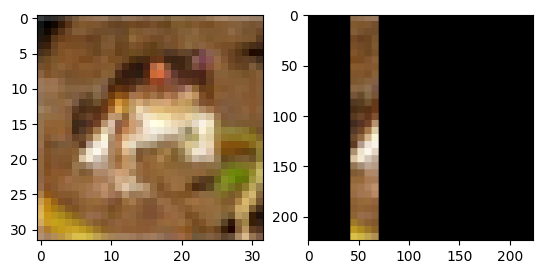

In [6]:
# We can see behind the scenes how PyTorchDeRandomizedSmoothing processes input by passing in the first few CIFAR
# images into art_model.ablator.forward along with a start position to retain pixels from the original image.
original_image = np.moveaxis(x_train, [1], [3])

ablated = art_model.ablator.forward(torch.from_numpy(x_train[0:10]).to(device), column_pos=6)
ablated = ablated.cpu().detach().numpy()

# Note the shape:
# - The ablator adds an extra channel to signify the ablated regions of the input.
# - The input is reshaped to be 224 x 224 to match the image shape that the ViT is expecting
print(f"The shape of the ablated image is {ablated.shape}")

ablated_image = ablated[:, 0:3, :, :]

# shift the axis to disply
ablated_image = np.moveaxis(ablated_image, [1], [3])

# plot the figure: Note the axis scale!
f, axarr = plt.subplots(1,2)
axarr[0].imshow(original_image[0])
axarr[1].imshow(ablated_image[0])

In [ ]:
# We can now train the model. This can take some time depending on hardware.
from torchvision import transforms

scheduler = torch.optim.lr_scheduler.MultiStepLR(art_model.optimizer, milestones=[10, 20], gamma=0.1)
art_model.fit(x_train, y_train, 
              nb_epochs=30, 
              update_batchnorm=True, 
              scheduler=scheduler,
              transform=transforms.Compose([transforms.RandomHorizontalFlip()]))
torch.save(art_model.model.state_dict(), 'trained.pt')

In [7]:
# Perform certification
art_model.model.load_state_dict(torch.load('trained.pt'))
acc, cert_acc = art_model.eval_and_certify(x_test, y_test, size_to_certify=4)

Normal Acc 0.902 Cert Acc 0.703: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [02:06<00:00,  1.61s/it]


Files already downloaded and verified
Files already downloaded and verified


INFO:root:Running algorithm: salman2021
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_small_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:art.estimators.classification.pytorch:Inferred 9 hidden layers on PyTorch classifier.
INFO:root:Running algorithm: salman2021


The shape of the ablated image is (10, 4, 224, 224)


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/vit_small_patch16_224.augreg_in21k_ft_in1k)
INFO:timm.models._hub:[timm/vit_small_patch16_224.augreg_in21k_ft_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:art.estimators.classification.pytorch:Inferred 9 hidden layers on PyTorch classifier.


The shape of the ablated image is (10, 4, 224, 224)


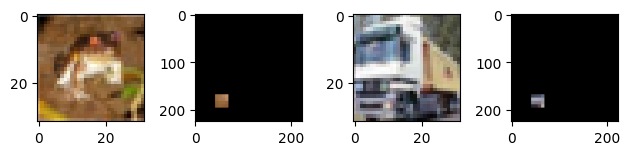

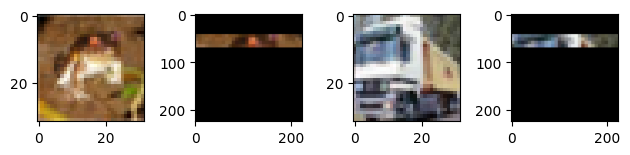

In [8]:
# We can also support different types of ablations. For example, we can use block or column ablations.

(x_train, y_train), (x_test, y_test) = get_cifar_data()
for ablation_type in ['block', 'row']:
    art_model = PyTorchDeRandomizedSmoothing(model='vit_small_patch16_224', # Name of the model acitecture to load
                                        loss=torch.nn.CrossEntropyLoss(), # loss function to use
                                        optimizer=torch.optim.SGD, # the optimizer to use: note! this is not initialised here we just supply the class!
                                        optimizer_params={"lr": 0.01}, # the parameters to use
                                        input_shape=(3, 32, 32), # the input shape of the data: Note! that if this is a different shape to what the ViT expects it will be re-scaled
                                        nb_classes=10,
                                        verbose=False,
                                        ablation_type=ablation_type,
                                        ablation_size=4, # Size of the retained column
                                        replace_last_layer=True, # Replace the last layer with a new set of weights to fine tune on new data
                                        load_pretrained=True) # if to load pre-trained weights for the ViT
    
    # We can see behind the scenes how PyTorchDeRandomizedSmoothing processes input by passing in the first few CIFAR
    # images into art_model.ablator.forward along with a start position to retain pixels from the original image.
    original_image = np.moveaxis(x_train, [1], [3])

    ablated = art_model.ablator.forward(torch.from_numpy(x_train[0:10]).to(device), column_pos=6)
    ablated = ablated.cpu().detach().numpy()

    # Note the shape:
    # - The ablator adds an extra channel to signify the ablated regions of the input.
    # - The input is reshaped to be 224 x 224 to match the image shape that the ViT is expecting
    print(f"The shape of the ablated image is {ablated.shape}")

    ablated_image = ablated[:, 0:3, :, :]
    
    # shift the axis to disply
    ablated_image = np.moveaxis(ablated_image, [1], [3])

    # plot the figure: Note the axis scale!
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(original_image[0])
    axarr[1].imshow(ablated_image[0])
    axarr[2].imshow(original_image[1])
    axarr[3].imshow(ablated_image[1])
    plt.tight_layout()

In [10]:
# The algorithm is general such that we do not have to supply only ViTs. 
# We can use regular CNNs as well, howevever we will loose the advantages 
# that were discussed at the start of the notebook. Here we will demonstrate it for a simple MNIST case 
# and also illustrate the use of the algorithm in https://arxiv.org/pdf/2002.10733.pdf

class MNISTModel(torch.nn.Module):

    def __init__(self):
        super(MNISTModel, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.conv_1 = torch.nn.Conv2d(in_channels=2, # input channels are doubled as per https://arxiv.org/pdf/2002.10733.pdf
                                      out_channels=64,
                                      kernel_size=4,
                                      stride=2,
                                      padding=1)

        self.conv_2 = torch.nn.Conv2d(in_channels=64,
                                      out_channels=128,
                                      kernel_size=4,
                                      stride=2, padding=1)

        self.fc1 = torch.nn.Linear(in_features=128*7*7, out_features=500)
        self.fc2 = torch.nn.Linear(in_features=500, out_features=100)
        self.fc3 = torch.nn.Linear(in_features=100, out_features=10)

        self.relu = torch.nn.ReLU()

    def forward(self, x: "torch.Tensor") -> "torch.Tensor":
        """
        Computes the forward pass though the neural network
        :param x: input data of shape (batch size, N features)
        :return: model prediction
        """
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

def get_mnist_data():
    """
    Get the MNIST data.
    """
    train_set = datasets.MNIST('./data', train=True, download=True)
    test_set = datasets.MNIST('./data', train=False, download=True)

    x_train = train_set.data.numpy().astype(np.float32)
    y_train = train_set.targets.numpy()

    x_test = test_set.data.numpy().astype(np.float32)
    y_test = test_set.targets.numpy()

    x_train = np.expand_dims(x_train, axis=1)
    x_test = np.expand_dims(x_test, axis=1)

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    return (x_train, y_train), (x_test, y_test)


model = MNISTModel()
(x_train, y_train), (x_test, y_test) = get_mnist_data()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

art_model = PyTorchDeRandomizedSmoothing(model=model,
                                         loss=torch.nn.CrossEntropyLoss(),
                                         optimizer=optimizer,
                                         input_shape=(1, 28, 28),
                                         nb_classes=10,
                                         ablation_type='column',
                                         algorithm='levine2020', # Algorithm selection
                                         threshold=0.3, # Requires a threshold
                                         ablation_size=2,
                                         logits=True)

scheduler = torch.optim.lr_scheduler.MultiStepLR(art_model.optimizer, milestones=[200], gamma=0.1)

# Uncomment to train.
'''
art_model.fit(x_train, y_train,
              nb_epochs=400,
              scheduler=scheduler)
torch.save(art_model.model.state_dict(), 'trained_mnist.pt')

'''
art_model.model.load_state_dict(torch.load('trained_mnist.pt'))
acc, cert_acc = art_model.eval_and_certify(x_test, y_test, size_to_certify=5)


INFO:root:Running algorithm: levine2020
INFO:art.estimators.classification.pytorch:Inferred 6 hidden layers on PyTorch classifier.
INFO:art.estimators.certification.derandomized_smoothing.pytorch:MNISTModel(
  (conv_1): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv_2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc1): Linear(in_features=6272, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
)
Normal Acc 0.965 Cert Acc 0.494: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:02<00:00, 33.61it/s]
